In [1]:
##source: https://medium.com/@yanis.labrak/how-to-train-a-custom-vision-transformer-vit-image-classifier-to-help-endoscopists-in-under-5-min-2e7e4110a353
#%%
#%% Packages
from hugsvision.dataio.VisionDataset import VisionDataset

from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTFeatureExtractor, ViTForImageClassification
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from torchvision import datasets, transforms


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cuda')

In [40]:
import os
import shutil
from sklearn.model_selection import train_test_split

main_dir = "./data"      
output_dir = "./datasplit" 
test_size = 0.1                      

for subfolder in os.listdir(main_dir):
    subfolder_path = os.path.join(main_dir, subfolder)
    
    if os.path.isdir(subfolder_path):
        images = os.listdir(subfolder_path)
        
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        
        # Create output subfolders for train and test sets
        train_output_subfolder = os.path.join(output_dir, "train", subfolder)
        test_output_subfolder = os.path.join(output_dir, "test", subfolder)
        os.makedirs(train_output_subfolder, exist_ok=True)
        os.makedirs(test_output_subfolder, exist_ok=True)
        
        # Copy images to the respective directories
        for image in train_images:
            shutil.copy(os.path.join(subfolder_path, image), train_output_subfolder)
        for image in test_images:
            shutil.copy(os.path.join(subfolder_path, image), test_output_subfolder)



In [3]:
# my goals is to train a model classifier via transofmer (ViT) by follow the example in the source,

In [9]:
train, test, id2label, label2id = VisionDataset.fromImageFolder(
    "./datasplit/train",
    test_ratio=0.1,
    balanced = True,
    augmentation=False,
    torch_vision=False,      
)


Split Datasets...
Balance train dataset...
The less represented label in train as 4500 occurrences
Size of train after balancing is 22500
Training Dataset Elements:  20250
+---------+-----------+---------+----------+--------+----------+-------+
| Dataset | colon_aca | colon_n | lung_aca | lung_n | lung_scc | Total |
+---------+-----------+---------+----------+--------+----------+-------+
|  Train  |   4054    |  4050   |   4025   |  4056  |   4065   | 20250 |
|  Test   |    446    |   450   |   475    |  444   |   435    | 2250  |
+---------+-----------+---------+----------+--------+----------+-------+


In [10]:
# Use ViTImageProcessor instead of ViTFeatureExtractor
from transformers import ViTImageProcessor


In [11]:
huggingface_model = 'google/vit-base-patch16-224-in21k'

# Initialize the model and move it to GPU
model = ViTForImageClassification.from_pretrained(
    huggingface_model,
    num_labels = len(label2id),
    label2id   = label2id,
    id2label   = id2label
).to(device)  # Move model to GPU

# Initialize the feature extractor
feature_extractor = ViTImageProcessor.from_pretrained(
        huggingface_model,)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

trainer = VisionClassifierTrainer(
	model_name   = "ColonLungClassifier",
	train        = train,
	test         = test,
	output_dir   = "./out/",
	max_epochs   = 20,
	batch_size   = 16, 
	lr	     = 2e-5,
	fp16	     = True,
	model = model,
	feature_extractor = feature_extractor,
)

In [24]:
y_true, y_pred = trainer.evaluate_f1_score()


100%|██████████| 2500/2500 [01:00<00:00, 41.55it/s]

              precision    recall  f1-score   support

   colon_aca     1.0000    1.0000    1.0000       486
     colon_n     1.0000    1.0000    1.0000       514
    lung_aca     1.0000    1.0000    1.0000       504
      lung_n     1.0000    1.0000    1.0000       515
    lung_scc     1.0000    1.0000    1.0000       481

    accuracy                         1.0000      2500
   macro avg     1.0000    1.0000    1.0000      2500
weighted avg     1.0000    1.0000    1.0000      2500

Logs saved at: ./out/COLONLUNGCLASSIFIER/20_2024-08-23-14-45-12


In [36]:
label2id.keys()

dict_keys(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'])

In [25]:
cm = confusion_matrix(y_true, y_pred)
labels = list(label2id.keys())
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
df_cm

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,486,0,0,0,0
colon_n,0,514,0,0,0
lung_aca,0,0,504,0,0
lung_n,0,0,0,515,0
lung_scc,0,0,0,0,481


<Axes: >

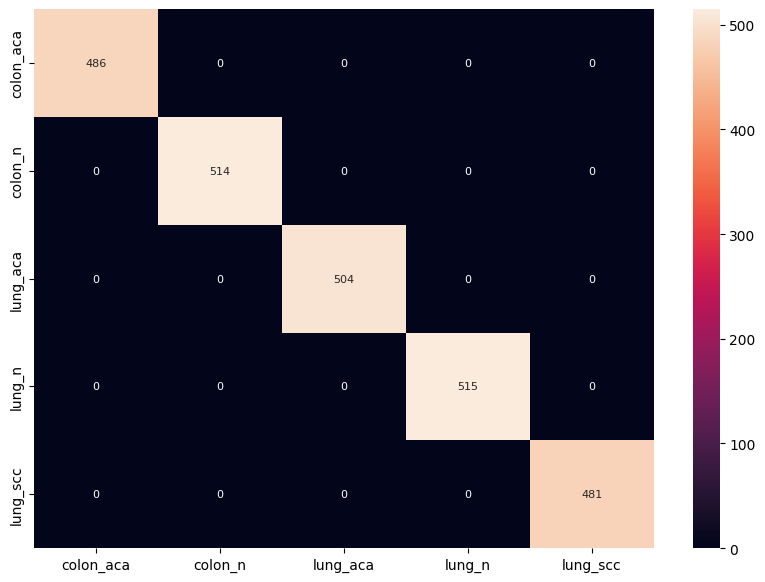

In [35]:
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt="")
#plt.savefig("./conf_matrix_1.jpg")


In [30]:
import os.path
path = "./out/COLONLUNGCLASSIFIER/20_2024-08-23-14-45-12/model"
img  = "./datasplit/test/lung_aca/lungaca5.jpeg"

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=img)
print("Predicted class:", label)

/home/hernan/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model loaded!
Predicted class: lung_aca


In [ ]:
# %% Test dataset
test, _, id2label, label2id = VisionDataset.fromImageFolder(
    "./datasplit/test/",
    test_ratio   = 0,
    balanced     = True,
    augmentation = True, 
    torch_vision = False
)

classifier.predict(img)

In [ ]:
import glob
test_files = [f for f in glob.glob("./test/**/**", recursive=True) if os.path.isfile(f)]
# %%
for i in range(len(test_files)):
	print(f"{test_files[i]}")
	print(f"predicted: {classifier.predict(test_files[i])}")
# %%
